In [1]:
from siamese_dataloader import Siamese_dataset, Siamese_dataloader
from torch import nn as nn
import torch
from torch import device, cuda, no_grad, cat
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

In [2]:
SEED = 2024

root="../train_xml"
# Raw data
subset = np.logical_not(np.load("data/missing_file_names_mask.npy")) # Makes losses adapt to the selected mouse_records
losses = np.load("data/resnet50_losses_final_weights.npy")[subset]
mouse_records = np.load("data/mouse_record_raw.npy")

# Clean data aka reasonable estimated time
estimate_times=np.load('data/sample_estimate_times.npy')
clean_subset = estimate_times[subset] < 3000
clean_subset = np.logical_and(clean_subset, estimate_times[subset] > 0)

losses = losses[clean_subset]
mouse_records = mouse_records[clean_subset]

# Train and test split
assert len(losses) == len(mouse_records)
indices = list(np.arange(len(losses)))
indices_randomized = np.random.choice(indices, int(len(indices)), replace=False)
train_indices = indices_randomized[:int(0.75*len(indices))]
test_indices = indices_randomized[int(0.8*len(indices)):]
val_indices = indices_randomized[int(0.75*len(indices)):int(0.8*len(indices))]

# train_indices = train_indices[:10000] # Lets overfit
losses_train = losses[train_indices]
mouse_records_train = mouse_records[train_indices]
dataset_train = Siamese_dataset(losses_train, mouse_records_train, seed=SEED)
dataloader_train = Siamese_dataloader(dataset_train, batch_size=4096, num_workers=8, shuffle=True).run()

losses_test = losses[test_indices]
mouse_records_test = mouse_records[test_indices]
dataset_test = Siamese_dataset(losses_test, mouse_records_test, seed=SEED)
dataloader_test = Siamese_dataloader(dataset_test, batch_size=4096, num_workers=8, shuffle=True).run()

val_indices=val_indices[:10000]
losses_val = losses[val_indices]
mouse_records_val = mouse_records[val_indices]
dataset_val = Siamese_dataset(losses_val, mouse_records_val, seed=SEED)
dataloader_val = Siamese_dataloader(dataset_val, batch_size=4096, num_workers=8, shuffle=True).run()

len(dataset_train), len(dataset_test), len(dataset_val)

(817734, 218063, 10000)

In [3]:
i = np.random.randint(0,10000)
i, np.argmin(mouse_records[i])//3,  mouse_records[i]

(868,
 0,
 array([[0.0000000e+00, 2.0370370e-01, 5.3992397e-01],
        [4.3000000e+01, 3.3024693e-01, 5.1711029e-01],
        [9.1000000e+01, 3.6111110e-01, 5.2091253e-01],
        [1.4300000e+02, 3.9814815e-01, 4.1064638e-01],
        [1.8400000e+02, 4.4753087e-01, 2.7756655e-01],
        [3.5300000e+02, 4.6296296e-01, 2.4714829e-01],
        [3.9300000e+02, 4.5987654e-01, 2.4714829e-01],
        [4.3300000e+02, 4.1049382e-01, 2.5855514e-01],
        [4.6900000e+02, 3.9197531e-01, 2.5855514e-01],
        [5.1400000e+02, 3.8580248e-01, 2.5855514e-01],
        [6.2500000e+02, 3.7962964e-01, 2.5855514e-01],
        [6.6800000e+02, 3.7037036e-01, 2.6996198e-01],
        [6.9900000e+02, 3.6419752e-01, 2.7756655e-01],
        [7.3200000e+02, 3.5802469e-01, 2.7756655e-01],
        [8.4400000e+02, 3.4567901e-01, 2.8136882e-01],
        [8.9000000e+02, 3.4567901e-01, 2.8517109e-01],
        [9.3800000e+02, 3.4876543e-01, 2.9657796e-01],
        [9.8600000e+02, 3.5185185e-01, 3.6501902e-01],


In [4]:
a = iter(Siamese_dataloader(dataset_train, batch_size=1, num_workers=1, shuffle=True, mouse_record_shape = (30,3)).run())

In [14]:
m0[0][:5]

tensor([[ 0.0000e+00,  3.8889e-01,  0.0000e+00],
        [ 4.0640e+03,  4.3519e-01, -4.8309e-03],
        [ 4.1020e+03,  3.8889e-01,  1.2560e-01],
        [ 4.1380e+03,  3.7654e-01,  1.5942e-01],
        [ 4.1670e+03,  3.7654e-01,  1.6425e-01]])

In [25]:
m0, m1, l, w = next(a)
m0[0,:2, :], m1[0,:2]

(tensor([[ 0.0000,  0.9568,  0.4509],
         [76.0000,  0.7870,  0.4509]]),
 tensor([[ 0.0000,  0.9214,  0.1941],
         [36.0000,  0.8821,  0.2235]]))

In [26]:
def train_one_epoch(train_loader, net, criterion, optimizer, epoch):
    running_loss = 0.0
    predictions = []
    all_labels = []
    for _, (inputs_0, inputs_1, labels, weights) in enumerate(train_loader, 0):
        inputs_0, inputs_1, labels, weights = inputs_0.to(device), inputs_1.to(device), labels.to(device), weights.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs_0, inputs_1)
        loss = criterion(outputs*weights, labels)
        loss.backward()
        optimizer.step()

        predictions.append(outputs)
        all_labels.append(labels)
        running_loss += loss.item()
    preds = cat(predictions)<0
    accuracy = (preds == cat(all_labels)).sum().item() / len(cat(predictions))
    return accuracy, running_loss

def test_one_epoch(loader, net, criterion):
    with no_grad():
        loss = 0
        predictions = []
        all_labels = []
        for _, (inputs_0, inputs_1, labels, _) in enumerate(loader, 0):
            inputs_0, inputs_1, labels = inputs_0.to(device), inputs_1.to(device), labels.to(device)
            outputs = net(inputs_0, inputs_1)
            predictions.append(outputs)
            all_labels.append(labels)
            loss += criterion(outputs, labels).item()

        predictions = cat(predictions)
        all_labels = cat(all_labels)
    preds = predictions<0
    accuracy = (preds == all_labels).sum().item() / len(predictions)
    return accuracy, loss

In [20]:
## Maybe try LSTM:
# https://github.com/yakhyo/pytorch-tutorials/blob/main/tutorials/03-intermediate/04-lstm-network/main.py
# TODO: Implement LSTM
class Siamese_network_LSTM(nn.Module):
    # It should predict 0, 1.
    # 0 if 1st sample has higher loss
    # 1 if 2nd sample has higher loss
    def __init__(self):
        super().__init__()

        # input is 30x3 dim and output is 1 dim
        self.shared_features = nn.Sequential(
            nn.Linear(60, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
        )

        self.classification_head = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Linear(16, 1),
            nn.ReLU(),
            nn.BatchNorm1d(1),
        )

    def forward(self, x, y):
        x = self.shared_features(x)
        y = self.shared_features(y)

        return self.classification_head(x * y)


In [21]:
cuda.is_available()

True

In [22]:
device = 'cuda:0' if cuda.is_available() else 'cpu'
print(f"Using device: {device}")

net = Siamese_network()
print(f"The number of parameters is {sum(p.numel() for p in net.parameters())}")
net.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.8)

accuracy, loss = test_one_epoch(dataloader_test, net, criterion)
print(f"Initial test accuracy is {accuracy} and loss is {loss}")

Using device: cuda:0
The number of parameters is 165923
Initial test accuracy is 0.4996491839514269 and loss is 42.45474821329117


In [23]:
EPOCHS = 100
training_accuracies = []
training_losses = []
val_accuracies = []
val_losses = []
for _, epoch in enumerate(tqdm(range(EPOCHS))):
    train_accuracy, loss = train_one_epoch(dataloader_train, net, criterion, optimizer, epoch)
    val_accuracy, v_loss = test_one_epoch(dataloader_val, net, criterion)
    training_accuracies.append(train_accuracy)
    training_losses.append(loss)
    val_accuracies.append(val_accuracy)
    val_losses.append(v_loss)
    
    print(f"Epoch: {epoch}/{EPOCHS} | Loss : {loss} | Train accuracy: {train_accuracy} | Val accuracy: {val_accuracy} | Val loss: {v_loss}")

accuracy, loss = test_one_epoch(dataloader_test, net, criterion)
print(f"Finished Training, final test accuracy is {accuracy} and loss is {loss}, final training accuracy is {train_accuracy}")


  1%|          | 1/100 [00:23<39:10, 23.75s/it]

Epoch: 0/100 | Loss : 142.03089302778244 | Train accuracy: 0.5017768614243752 | Val accuracy: 0.5018 | Val loss: 2.3369413018226624


  2%|▏         | 2/100 [00:46<37:28, 22.95s/it]

Epoch: 1/100 | Loss : 139.74613654613495 | Train accuracy: 0.5006530240885178 | Val accuracy: 0.4985 | Val loss: 2.335801661014557


  3%|▎         | 3/100 [01:09<37:18, 23.08s/it]

Epoch: 2/100 | Loss : 139.43912541866302 | Train accuracy: 0.5004769277050972 | Val accuracy: 0.4995 | Val loss: 2.3245946168899536


  4%|▍         | 4/100 [01:32<36:56, 23.08s/it]

Epoch: 3/100 | Loss : 139.2428441643715 | Train accuracy: 0.5007814277014285 | Val accuracy: 0.5026 | Val loss: 2.3170384764671326


  5%|▌         | 5/100 [01:54<35:55, 22.69s/it]

Epoch: 4/100 | Loss : 139.1075404882431 | Train accuracy: 0.5006200060166265 | Val accuracy: 0.4964 | Val loss: 2.3149916529655457


  6%|▌         | 6/100 [02:18<36:05, 23.04s/it]

Epoch: 5/100 | Loss : 139.00383752584457 | Train accuracy: 0.5001039457818802 | Val accuracy: 0.5014 | Val loss: 2.318816602230072


  7%|▋         | 7/100 [02:40<35:22, 22.82s/it]

Epoch: 6/100 | Loss : 138.9305145740509 | Train accuracy: 0.5004879337290611 | Val accuracy: 0.501 | Val loss: 2.310005247592926


  8%|▊         | 8/100 [03:03<34:59, 22.82s/it]

Epoch: 7/100 | Loss : 138.8808817267418 | Train accuracy: 0.500874367459345 | Val accuracy: 0.4997 | Val loss: 2.304540693759918


  9%|▉         | 9/100 [03:26<34:50, 22.97s/it]

Epoch: 8/100 | Loss : 138.82753264904022 | Train accuracy: 0.5001846566242812 | Val accuracy: 0.499 | Val loss: 2.303317904472351


 10%|█         | 10/100 [03:48<34:06, 22.74s/it]

Epoch: 9/100 | Loss : 138.79547709226608 | Train accuracy: 0.500214006021518 | Val accuracy: 0.496 | Val loss: 2.3040889501571655


 11%|█         | 11/100 [04:12<34:20, 23.15s/it]

Epoch: 10/100 | Loss : 138.76591902971268 | Train accuracy: 0.5003460783090834 | Val accuracy: 0.4987 | Val loss: 2.3020907044410706


 12%|█▏        | 12/100 [04:36<34:03, 23.22s/it]

Epoch: 11/100 | Loss : 138.74016803503036 | Train accuracy: 0.5000550301198189 | Val accuracy: 0.4998 | Val loss: 2.3026559352874756


 13%|█▎        | 13/100 [04:59<33:42, 23.25s/it]

Epoch: 12/100 | Loss : 138.7271145582199 | Train accuracy: 0.5000635903606796 | Val accuracy: 0.5016 | Val loss: 2.305077314376831


 14%|█▍        | 14/100 [05:24<33:49, 23.59s/it]

Epoch: 13/100 | Loss : 138.71536874771118 | Train accuracy: 0.5004218975852783 | Val accuracy: 0.4995 | Val loss: 2.2999268770217896


 15%|█▌        | 15/100 [05:47<33:27, 23.61s/it]

Epoch: 14/100 | Loss : 138.70745354890823 | Train accuracy: 0.5002727048159915 | Val accuracy: 0.4965 | Val loss: 2.2995084524154663


 16%|█▌        | 16/100 [06:11<33:12, 23.72s/it]

Epoch: 15/100 | Loss : 138.69220209121704 | Train accuracy: 0.49969794578677174 | Val accuracy: 0.5008 | Val loss: 2.2982726097106934


 17%|█▋        | 17/100 [06:35<32:40, 23.62s/it]

Epoch: 16/100 | Loss : 138.69105923175812 | Train accuracy: 0.5003717590316655 | Val accuracy: 0.5041 | Val loss: 2.301602840423584


 18%|█▊        | 18/100 [06:58<32:08, 23.52s/it]

Epoch: 17/100 | Loss : 138.68628692626953 | Train accuracy: 0.500409668669763 | Val accuracy: 0.5003 | Val loss: 2.3035470843315125


 19%|█▉        | 19/100 [07:22<31:56, 23.66s/it]

Epoch: 18/100 | Loss : 138.67968863248825 | Train accuracy: 0.5001650903594568 | Val accuracy: 0.5001 | Val loss: 2.306516647338867


 20%|██        | 20/100 [07:46<31:33, 23.67s/it]

Epoch: 19/100 | Loss : 138.67606633901596 | Train accuracy: 0.5001919939735905 | Val accuracy: 0.4992 | Val loss: 2.304814636707306


 21%|██        | 21/100 [08:09<31:14, 23.73s/it]

Epoch: 20/100 | Loss : 138.6707143187523 | Train accuracy: 0.49992907229001116 | Val accuracy: 0.4986 | Val loss: 2.2962961196899414


 22%|██▏       | 22/100 [08:33<30:41, 23.61s/it]

Epoch: 21/100 | Loss : 138.66832220554352 | Train accuracy: 0.5000134518070668 | Val accuracy: 0.503 | Val loss: 2.2947937846183777


 23%|██▎       | 23/100 [08:56<30:08, 23.49s/it]

Epoch: 22/100 | Loss : 138.66422319412231 | Train accuracy: 0.4997872168700335 | Val accuracy: 0.4989 | Val loss: 2.286387324333191


 24%|██▍       | 24/100 [09:20<30:02, 23.72s/it]

Epoch: 23/100 | Loss : 138.6627783179283 | Train accuracy: 0.5000917168663649 | Val accuracy: 0.5013 | Val loss: 2.2973238825798035


 25%|██▌       | 25/100 [09:44<29:45, 23.81s/it]

Epoch: 24/100 | Loss : 138.65879142284393 | Train accuracy: 0.5002824879484038 | Val accuracy: 0.499 | Val loss: 2.296111762523651


 26%|██▌       | 26/100 [10:08<29:24, 23.85s/it]

Epoch: 25/100 | Loss : 138.65506941080093 | Train accuracy: 0.5001088373480863 | Val accuracy: 0.5008 | Val loss: 2.2946304082870483


 27%|██▋       | 27/100 [10:32<28:57, 23.80s/it]

Epoch: 26/100 | Loss : 138.6586298942566 | Train accuracy: 0.5004267891514844 | Val accuracy: 0.4977 | Val loss: 2.3082252144813538


 28%|██▊       | 28/100 [10:55<28:23, 23.65s/it]

Epoch: 27/100 | Loss : 138.6544097661972 | Train accuracy: 0.5001406325284261 | Val accuracy: 0.4967 | Val loss: 2.3018932342529297


 29%|██▉       | 29/100 [11:19<28:07, 23.76s/it]

Epoch: 28/100 | Loss : 138.65198731422424 | Train accuracy: 0.5001699819256629 | Val accuracy: 0.5013 | Val loss: 2.2905483841896057


 30%|███       | 30/100 [11:42<27:23, 23.48s/it]

Epoch: 29/100 | Loss : 138.65460366010666 | Train accuracy: 0.5003827650556293 | Val accuracy: 0.5025 | Val loss: 2.3093801140785217


 31%|███       | 31/100 [12:06<27:01, 23.50s/it]

Epoch: 30/100 | Loss : 138.6515691280365 | Train accuracy: 0.4999755421689694 | Val accuracy: 0.4999 | Val loss: 2.310658574104309


 32%|███▏      | 32/100 [12:29<26:41, 23.55s/it]

Epoch: 31/100 | Loss : 138.64901167154312 | Train accuracy: 0.49986181325467693 | Val accuracy: 0.4956 | Val loss: 2.290321409702301


 33%|███▎      | 33/100 [12:52<26:05, 23.37s/it]

Epoch: 32/100 | Loss : 138.6471785902977 | Train accuracy: 0.4999254036153566 | Val accuracy: 0.5005 | Val loss: 2.3033228516578674


 34%|███▍      | 34/100 [13:16<25:56, 23.58s/it]

Epoch: 33/100 | Loss : 138.64919996261597 | Train accuracy: 0.500409668669763 | Val accuracy: 0.5025 | Val loss: 2.295770049095154


 35%|███▌      | 35/100 [13:40<25:46, 23.79s/it]

Epoch: 34/100 | Loss : 138.64817130565643 | Train accuracy: 0.5000464698789582 | Val accuracy: 0.501 | Val loss: 2.295841693878174


 36%|███▌      | 36/100 [14:04<25:21, 23.77s/it]

Epoch: 35/100 | Loss : 138.64710915088654 | Train accuracy: 0.5000733734930919 | Val accuracy: 0.4999 | Val loss: 2.29391872882843


 37%|███▋      | 37/100 [14:28<24:49, 23.64s/it]

Epoch: 36/100 | Loss : 138.64616453647614 | Train accuracy: 0.5003803192725262 | Val accuracy: 0.4981 | Val loss: 2.3060295581817627


 38%|███▊      | 38/100 [14:50<24:06, 23.33s/it]

Epoch: 37/100 | Loss : 138.64410144090652 | Train accuracy: 0.5000305722887883 | Val accuracy: 0.4959 | Val loss: 2.2983990907669067


 39%|███▉      | 39/100 [15:14<23:46, 23.38s/it]

Epoch: 38/100 | Loss : 138.64518505334854 | Train accuracy: 0.5001198433720501 | Val accuracy: 0.5025 | Val loss: 2.2988728880882263


 40%|████      | 40/100 [15:37<23:13, 23.22s/it]

Epoch: 39/100 | Loss : 138.64470267295837 | Train accuracy: 0.5004035542120053 | Val accuracy: 0.4997 | Val loss: 2.3139438033103943


 41%|████      | 41/100 [15:59<22:44, 23.13s/it]

Epoch: 40/100 | Loss : 138.64113801717758 | Train accuracy: 0.49993151807311426 | Val accuracy: 0.498 | Val loss: 2.30092191696167


 42%|████▏     | 42/100 [16:23<22:30, 23.28s/it]

Epoch: 41/100 | Loss : 138.6450737118721 | Train accuracy: 0.5003020542132283 | Val accuracy: 0.5032 | Val loss: 2.30507630109787


 43%|████▎     | 43/100 [16:46<21:55, 23.09s/it]

Epoch: 42/100 | Loss : 138.64012330770493 | Train accuracy: 0.5001712048172144 | Val accuracy: 0.5 | Val loss: 2.3026965260505676


 44%|████▍     | 44/100 [17:09<21:36, 23.14s/it]

Epoch: 43/100 | Loss : 138.6411148905754 | Train accuracy: 0.4998190120503733 | Val accuracy: 0.4963 | Val loss: 2.3025532364845276


 45%|████▌     | 45/100 [17:33<21:28, 23.43s/it]

Epoch: 44/100 | Loss : 138.64123982191086 | Train accuracy: 0.4998532530138162 | Val accuracy: 0.5002 | Val loss: 2.2982287406921387


 46%|████▌     | 46/100 [17:56<21:04, 23.41s/it]

Epoch: 45/100 | Loss : 138.63965344429016 | Train accuracy: 0.4996025602457523 | Val accuracy: 0.5034 | Val loss: 2.295968234539032


 47%|████▋     | 47/100 [18:20<20:46, 23.52s/it]

Epoch: 46/100 | Loss : 138.6402319073677 | Train accuracy: 0.5001259578298077 | Val accuracy: 0.4994 | Val loss: 2.2976368069648743


 48%|████▊     | 48/100 [18:43<20:09, 23.26s/it]

Epoch: 47/100 | Loss : 138.64085191488266 | Train accuracy: 0.49979822289399733 | Val accuracy: 0.4985 | Val loss: 2.301190137863159


 49%|████▉     | 49/100 [19:06<19:48, 23.31s/it]

Epoch: 48/100 | Loss : 138.64061391353607 | Train accuracy: 0.5002580301173731 | Val accuracy: 0.5031 | Val loss: 2.306664764881134


 50%|█████     | 50/100 [19:30<19:23, 23.28s/it]

Epoch: 49/100 | Loss : 138.6397454738617 | Train accuracy: 0.4997700963883121 | Val accuracy: 0.5072 | Val loss: 2.2953110337257385


 51%|█████     | 51/100 [19:52<18:54, 23.15s/it]

Epoch: 50/100 | Loss : 138.641641497612 | Train accuracy: 0.4999413012055265 | Val accuracy: 0.4936 | Val loss: 2.303346574306488


 52%|█████▏    | 52/100 [20:16<18:39, 23.32s/it]

Epoch: 51/100 | Loss : 138.6413078904152 | Train accuracy: 0.4996551445824681 | Val accuracy: 0.4985 | Val loss: 2.3005136251449585


 53%|█████▎    | 53/100 [20:39<18:09, 23.18s/it]

Epoch: 52/100 | Loss : 138.6397209763527 | Train accuracy: 0.5001736506003175 | Val accuracy: 0.4974 | Val loss: 2.3045517802238464


 54%|█████▍    | 54/100 [21:02<17:43, 23.12s/it]

Epoch: 53/100 | Loss : 138.63908010721207 | Train accuracy: 0.4995878855471339 | Val accuracy: 0.499 | Val loss: 2.296653687953949


 55%|█████▌    | 55/100 [21:26<17:33, 23.40s/it]

Epoch: 54/100 | Loss : 138.63913625478745 | Train accuracy: 0.5005111686685402 | Val accuracy: 0.5007 | Val loss: 2.3075051307678223


 56%|█████▌    | 56/100 [21:49<17:04, 23.29s/it]

Epoch: 55/100 | Loss : 138.63865798711777 | Train accuracy: 0.4998324638574402 | Val accuracy: 0.5043 | Val loss: 2.2967769503593445


 57%|█████▋    | 57/100 [22:12<16:41, 23.30s/it]

Epoch: 56/100 | Loss : 138.6367090344429 | Train accuracy: 0.49992295783225354 | Val accuracy: 0.5003 | Val loss: 2.293213427066803


 58%|█████▊    | 58/100 [22:34<16:04, 22.95s/it]

Epoch: 57/100 | Loss : 138.63789081573486 | Train accuracy: 0.4999070602420836 | Val accuracy: 0.4917 | Val loss: 2.2889689803123474


 59%|█████▉    | 59/100 [22:56<15:29, 22.67s/it]

Epoch: 58/100 | Loss : 138.635968208313 | Train accuracy: 0.5001675361425598 | Val accuracy: 0.5029 | Val loss: 2.2959293127059937


 60%|██████    | 60/100 [23:20<15:17, 22.93s/it]

Epoch: 59/100 | Loss : 138.63665944337845 | Train accuracy: 0.4995218494033512 | Val accuracy: 0.4972 | Val loss: 2.296839475631714


 61%|██████    | 61/100 [23:42<14:39, 22.55s/it]

Epoch: 60/100 | Loss : 138.6405519247055 | Train accuracy: 0.5011751987810217 | Val accuracy: 0.5001 | Val loss: 2.2997690439224243


 62%|██████▏   | 62/100 [24:05<14:23, 22.71s/it]

Epoch: 61/100 | Loss : 138.63866686820984 | Train accuracy: 0.5002837108399553 | Val accuracy: 0.5016 | Val loss: 2.306764543056488


 63%|██████▎   | 63/100 [24:28<14:10, 23.00s/it]

Epoch: 62/100 | Loss : 138.63552290201187 | Train accuracy: 0.5004573614402728 | Val accuracy: 0.4982 | Val loss: 2.2923855781555176


 64%|██████▍   | 64/100 [24:51<13:46, 22.96s/it]

Epoch: 63/100 | Loss : 138.63665342330933 | Train accuracy: 0.5002763734906461 | Val accuracy: 0.4981 | Val loss: 2.2873483300209045


 65%|██████▌   | 65/100 [25:15<13:32, 23.22s/it]

Epoch: 64/100 | Loss : 138.6366970539093 | Train accuracy: 0.49988137951950146 | Val accuracy: 0.4954 | Val loss: 2.2960057854652405


 66%|██████▌   | 66/100 [25:38<13:09, 23.23s/it]

Epoch: 65/100 | Loss : 138.63604140281677 | Train accuracy: 0.5001100602396378 | Val accuracy: 0.5023 | Val loss: 2.2992942333221436


 67%|██████▋   | 67/100 [26:01<12:45, 23.18s/it]

Epoch: 66/100 | Loss : 138.6356599330902 | Train accuracy: 0.49949983735542364 | Val accuracy: 0.5011 | Val loss: 2.2953585386276245


 68%|██████▊   | 68/100 [26:25<12:22, 23.21s/it]

Epoch: 67/100 | Loss : 138.6365403532982 | Train accuracy: 0.5004867108375095 | Val accuracy: 0.5038 | Val loss: 2.291821241378784


 69%|██████▉   | 69/100 [26:47<11:52, 23.00s/it]

Epoch: 68/100 | Loss : 138.63603633642197 | Train accuracy: 0.4998006686771004 | Val accuracy: 0.5015 | Val loss: 2.307884454727173


 70%|███████   | 70/100 [27:11<11:32, 23.09s/it]

Epoch: 69/100 | Loss : 138.63576674461365 | Train accuracy: 0.5003766505978717 | Val accuracy: 0.5034 | Val loss: 2.2946820855140686


 71%|███████   | 71/100 [27:33<11:05, 22.95s/it]

Epoch: 70/100 | Loss : 138.63548570871353 | Train accuracy: 0.4990547048306662 | Val accuracy: 0.5013 | Val loss: 2.307124137878418


 72%|███████▏  | 72/100 [27:56<10:37, 22.77s/it]

Epoch: 71/100 | Loss : 138.63737380504608 | Train accuracy: 0.49974808434038454 | Val accuracy: 0.5065 | Val loss: 2.300095319747925


 73%|███████▎  | 73/100 [28:19<10:20, 22.99s/it]

Epoch: 72/100 | Loss : 138.63813388347626 | Train accuracy: 0.49993151807311426 | Val accuracy: 0.5033 | Val loss: 2.2923734188079834


 74%|███████▍  | 74/100 [28:42<09:54, 22.86s/it]

Epoch: 73/100 | Loss : 138.63445049524307 | Train accuracy: 0.5000953855410194 | Val accuracy: 0.5042 | Val loss: 2.303052604198456


 75%|███████▌  | 75/100 [29:05<09:32, 22.90s/it]

Epoch: 74/100 | Loss : 138.6344347000122 | Train accuracy: 0.5002360180694456 | Val accuracy: 0.497 | Val loss: 2.2981609106063843


 76%|███████▌  | 76/100 [29:29<09:18, 23.29s/it]

Epoch: 75/100 | Loss : 138.63608664274216 | Train accuracy: 0.5005820963785289 | Val accuracy: 0.4984 | Val loss: 2.2931089401245117


 77%|███████▋  | 77/100 [29:52<08:53, 23.21s/it]

Epoch: 76/100 | Loss : 138.63455438613892 | Train accuracy: 0.4997603132558998 | Val accuracy: 0.4973 | Val loss: 2.2957262992858887


 78%|███████▊  | 78/100 [30:15<08:32, 23.32s/it]

Epoch: 77/100 | Loss : 138.63460224866867 | Train accuracy: 0.500388879513387 | Val accuracy: 0.5002 | Val loss: 2.3011828660964966


 79%|███████▉  | 79/100 [30:38<08:03, 23.04s/it]

Epoch: 78/100 | Loss : 138.63757264614105 | Train accuracy: 0.5004659216811335 | Val accuracy: 0.5034 | Val loss: 2.291611075401306


 80%|████████  | 80/100 [31:00<07:37, 22.88s/it]

Epoch: 79/100 | Loss : 138.6380045413971 | Train accuracy: 0.50001589759017 | Val accuracy: 0.5005 | Val loss: 2.295316219329834


 81%|████████  | 81/100 [31:24<07:17, 23.05s/it]

Epoch: 80/100 | Loss : 138.63476449251175 | Train accuracy: 0.4997040602445294 | Val accuracy: 0.502 | Val loss: 2.292204737663269


 82%|████████▏ | 82/100 [31:46<06:52, 22.93s/it]

Epoch: 81/100 | Loss : 138.63523298501968 | Train accuracy: 0.49977376506296667 | Val accuracy: 0.5005 | Val loss: 2.305359423160553


 83%|████████▎ | 83/100 [32:10<06:31, 23.03s/it]

Epoch: 82/100 | Loss : 138.63399404287338 | Train accuracy: 0.49997065060276324 | Val accuracy: 0.4989 | Val loss: 2.3058826327323914


 84%|████████▍ | 84/100 [32:32<06:07, 22.98s/it]

Epoch: 83/100 | Loss : 138.63405323028564 | Train accuracy: 0.5005307349333646 | Val accuracy: 0.4992 | Val loss: 2.3086737990379333


 85%|████████▌ | 85/100 [32:55<05:42, 22.85s/it]

Epoch: 84/100 | Loss : 138.6365591287613 | Train accuracy: 0.4998764879532953 | Val accuracy: 0.502 | Val loss: 2.3110815286636353


 86%|████████▌ | 86/100 [33:19<05:23, 23.12s/it]

Epoch: 85/100 | Loss : 138.63392543792725 | Train accuracy: 0.49981412048416723 | Val accuracy: 0.5053 | Val loss: 2.2990358471870422


 87%|████████▋ | 87/100 [33:42<05:01, 23.16s/it]

Epoch: 86/100 | Loss : 138.63475584983826 | Train accuracy: 0.5002580301173731 | Val accuracy: 0.4933 | Val loss: 2.2992796301841736


 88%|████████▊ | 88/100 [34:05<04:38, 23.21s/it]

Epoch: 87/100 | Loss : 138.63360214233398 | Train accuracy: 0.500114951805844 | Val accuracy: 0.497 | Val loss: 2.3002359867095947


 89%|████████▉ | 89/100 [34:28<04:15, 23.19s/it]

Epoch: 88/100 | Loss : 138.63320809602737 | Train accuracy: 0.49988871686881065 | Val accuracy: 0.499 | Val loss: 2.3010843992233276


 90%|█████████ | 90/100 [34:51<03:49, 22.98s/it]

Epoch: 89/100 | Loss : 138.6355865597725 | Train accuracy: 0.4996624819317773 | Val accuracy: 0.4984 | Val loss: 2.29612135887146


 91%|█████████ | 91/100 [35:14<03:28, 23.13s/it]

Epoch: 90/100 | Loss : 138.63487976789474 | Train accuracy: 0.5002800421653006 | Val accuracy: 0.5071 | Val loss: 2.2956891655921936


 92%|█████████▏| 92/100 [35:37<03:03, 22.97s/it]

Epoch: 91/100 | Loss : 138.6364397406578 | Train accuracy: 0.4997847710869305 | Val accuracy: 0.5031 | Val loss: 2.2948029041290283


 93%|█████████▎| 93/100 [36:00<02:40, 22.86s/it]

Epoch: 92/100 | Loss : 138.63521802425385 | Train accuracy: 0.4999914397591393 | Val accuracy: 0.4996 | Val loss: 2.2893736362457275


 94%|█████████▍| 94/100 [36:23<02:17, 22.96s/it]

Epoch: 93/100 | Loss : 138.63340038061142 | Train accuracy: 0.49990461445898055 | Val accuracy: 0.5045 | Val loss: 2.2987152338027954


 95%|█████████▌| 95/100 [36:45<01:53, 22.74s/it]

Epoch: 94/100 | Loss : 138.6331000328064 | Train accuracy: 0.49964169277540127 | Val accuracy: 0.5001 | Val loss: 2.308458983898163


 96%|█████████▌| 96/100 [37:08<01:31, 22.79s/it]

Epoch: 95/100 | Loss : 138.63468259572983 | Train accuracy: 0.5002983855385736 | Val accuracy: 0.5003 | Val loss: 2.2937272787094116


 97%|█████████▋| 97/100 [37:31<01:08, 22.74s/it]

Epoch: 96/100 | Loss : 138.63467794656754 | Train accuracy: 0.5006946024012698 | Val accuracy: 0.5045 | Val loss: 2.3024814128875732


 98%|█████████▊| 98/100 [37:52<00:44, 22.39s/it]

Epoch: 97/100 | Loss : 138.63406401872635 | Train accuracy: 0.4993897771157858 | Val accuracy: 0.4951 | Val loss: 2.3091805577278137


 99%|█████████▉| 99/100 [38:15<00:22, 22.61s/it]

Epoch: 98/100 | Loss : 138.6334896683693 | Train accuracy: 0.5004769277050972 | Val accuracy: 0.4989 | Val loss: 2.297061026096344


100%|██████████| 100/100 [38:37<00:00, 23.18s/it]

Epoch: 99/100 | Loss : 138.6352578997612 | Train accuracy: 0.500214006021518 | Val accuracy: 0.4993 | Val loss: 2.292341887950897


Finished Training, final test accuracy is 0.49856234207545524 and loss is 41.3557767868042, final training accuracy is 0.500214006021518


In [106]:
mr0, mr1, l, w = next(iter(dataloader_train))

In [57]:
c = 0
for s in w:
    c+=torch.allclose(s, torch.zeros_like(s))
    if c ==1:
        print(s)
        break
c, len(w), sum(l)

tensor([0.])


(1, 1000, tensor([500.]))

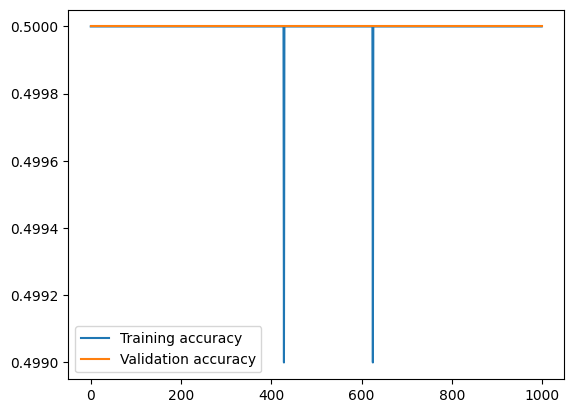

In [107]:
plt.plot(training_accuracies, label="Training accuracy")
plt.plot(val_accuracies, label="Validation accuracy")
plt.legend()